# Big Data Tools 2022-2023
# Group 4: Alice Degonzague, Nandini Gantayat, Cyril Kancel

In [0]:
#Please replace the path with yours
path = "/FileStore/tables/Data/"

In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import lit, to_timestamp, to_date, mean, median, isnan, when, count, isnull

In [0]:
def read_data(spark, path):
    order_items = spark.read.format("csv").option("header","true").option("inferSchema","true").load(path + "order_items.csv")
    order_payments = spark.read.format("csv").option("header","true").option("inferSchema","true").load(path + "order_payments.csv")
    order_reviews = spark.read.format("csv").option("header","true").option("inferSchema","true").load(path + "order_reviews.csv")
    orders = spark.read.format("csv").option("header","true").option("inferSchema","true").load(path + "orders.csv")
    products = spark.read.format("csv").option("header","true").option("inferSchema","true").load(path + "products.csv")
    return order_items, order_payments, order_reviews, orders, products

order_items, order_payments, order_reviews, orders, products = read_data(spark, path)

In [0]:
from pyspark.sql.functions import max as spark_max
from pyspark.sql.functions import col

def clean_order_reviews(order_reviews):
    
    #Date Columns
    date_cols = ['review_answer_timestamp', 'review_creation_date']
    for col in date_cols:
        order_reviews = order_reviews.withColumn(col, to_timestamp(lit(order_reviews[col]), "yyyy-M-d HH:mm:ss"))
    
    #Nas
    order_reviews = order_reviews.na.drop("any")
        
    #Duplicates
    order_reviews_df = order_reviews.toPandas()
    order_reviews_df = order_reviews_df.drop_duplicates(subset = "review_id", keep = False)
    order_reviews_df = order_reviews_df.sort_values('review_answer_timestamp').drop_duplicates('order_id', keep='last')
    order_reviews_final = spark.createDataFrame(order_reviews_df)
    
    
    return order_reviews_final

order_reviews_final = clean_order_reviews(order_reviews)

In [0]:
from pyspark.sql import DataFrame
from pyspark.sql.functions import sum, max, min, count, round
from pyspark.sql.types import IntegerType

def clean_order_payments(order_payments):
    
    #Aggregate values per payment type
    order_pivoted = order_payments\
    .groupBy(["order_id"])\
    .pivot("payment_type")\
    .agg(count("payment_type").cast(IntegerType()).alias('count'),\
         sum("payment_value").alias("total_payment_value"))\
    .na.fill(0)
    
    #Aggregate the rest of the value per order
    order_aggregated = order_payments\
    .drop("payment_type")\
    .groupBy(["order_id"])\
    .agg(max("payment_sequential").alias('payment_sequential'),\
         max("payment_installments").alias('payment_installments'),\
         sum("payment_value").alias('total_payment_value'))
    
    #Join the two tables
    order_payments_final = order_aggregated.join(order_pivoted, on = "order_id", how = "left")
    
    #Create ratio column
    order_payments_final = order_payments_final.withColumn("payment_installment_ratio", round(col("total_payment_value")/col("payment_installments"),2))
    
    return order_payments_final

order_payments_final = clean_order_payments(order_payments)

In [0]:
from pyspark.sql.functions import count, mean, sum

def clean_order_items_products(order_items, products):
    
    # Aggregate information per product category
    from pyspark.sql.functions import max, desc

    # Get the maximum price for each product and order
    order_category = order_items\
    .join(products, on = "product_id", how = 'left')\
    .na.drop("any")\
    .groupBy("order_id", "product_category_name")\
    .agg(max("price").alias("max_price_category"))\
    .orderBy("order_id", "max_price_category")
    
    order_category = order_category.toPandas()
    order_category2 = order_category.drop_duplicates('order_id', keep='first')
    order_category_final = spark.createDataFrame(order_category2).drop("max_price_category")
    
    # Aggregate information per order
    order_aggregated = order_items\
    .join(products, on = "product_id", how = 'left')\
    .drop("product_id", "order_item_id")\
    .na.drop("any")\
    .groupBy("order_id")\
    .agg(max("shipping_cost").alias("order_shipping_cost"),\
         min("product_photos_qty").alias("min_nb_photos"),\
         max("product_photos_qty").alias("max_nb_photos"),\
         mean("product_photos_qty").alias("mean_nb_photos"),\
         min("product_name_lenght").alias("min_product_name_lenght"),\
         max("product_name_lenght").alias("maxproduct_name_lenght"),\
         mean("product_name_lenght").alias("mean_product_name_lenght"),\
         min("product_description_lenght").alias("min_product_description_lenght"),\
         max("product_description_lenght").alias("max_product_description_lenght"),\
         mean("product_description_lenght").alias("mean_product_description_lenght"),\
         sum("product_weight_g").alias("approx_parcel_weight"),\
         max("product_height_cm").alias("approx_parcel_height_cm"),\
         max("product_width_cm").alias("approx_parcel_width_cm"))
    
    # Create ratio
    order_ratio = order_items\
    .join(products,  on = "product_id", how = 'left')\
    .na.drop("any")\
    .groupBy("order_id")\
    .agg(round((max("shipping_cost")/sum("price")),2)\
    .alias("cost_price_ratio"))
     
    
    # Final join for the 3 table
    order_items_final = order_aggregated\
    .join(order_category_final, on = "order_id", how = 'left')\
    .join(order_ratio,  on = "order_id", how = 'left')

    return order_items_final

order_items_final = clean_order_items_products(order_items, products)

In [0]:
from pyspark.sql.types import *
from pyspark.sql import Window
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.sql.functions import asc,  row_number

def clean_orders(orders):
    #Date Columns
    date_cols = ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date','order_estimated_delivery_date']
    for col in date_cols:
        orders = orders.withColumn(col, to_timestamp(lit(orders[col]), "yyyy-M-d HH:mm:ss"))
        
    #Nas
    orders = orders.filter(~(orders["order_id"] == 'NA') | (isnan(orders["order_id"])) | isnull(orders["order_id"]))
    
    #Create a column that counts the total number of order per customer
    orders_grouped = orders.groupBy("customer_id").agg(count("order_id").alias("order_count"))

    #Create a column that counts the total number of order per customer
    orders_grouped = orders_grouped.withColumn("loyalty", when(orders_grouped["order_count"] > 1, 1).otherwise(0))
   
    #Join the orders and orders_grouped dataframes
    orders = orders.join(orders_grouped, "customer_id", "left")
    
    #Create a column that indicates the customer's total number of order at the time of the order
    orders = orders.orderBy(asc("customer_id"), asc("order_purchase_timestamp"))
    window = Window.partitionBy("customer_id").orderBy("order_purchase_timestamp")
    orders = orders.withColumn("order_number", row_number().over(window))
    
    return orders

orders_final = clean_orders(orders)

In [0]:
def join_all(order_reviews_final, order_payments_final, orders_final, order_items_final):
    basetable = order_reviews_final\
    .join(order_payments_final, on = "order_id", how = "left")\
    .join(orders_final, on = "order_id", how = "left")\
    .join(order_items_final, on = "order_id", how = "left")
    return basetable

basetable = join_all(order_reviews_final, order_payments_final, orders_final, order_items_final)

In [0]:
from pyspark.sql.functions import datediff

#Creating time difference variables

def dates_info(basetable):
    basetable = basetable.withColumn("approval_time_difference_with_purchase", datediff(col("order_approved_at"), col("order_purchase_timestamp")))
    basetable = basetable.withColumn("delivered_carrier_time_difference_with_purchase", datediff(col("order_delivered_carrier_date"), col("order_purchase_timestamp")))
    basetable = basetable.withColumn("delivered_customer_time_difference_with_purchase", datediff(col("order_delivered_customer_date"), col("order_purchase_timestamp")))
    basetable = basetable.withColumn("estimate_delivery_time_difference_with_purchase", datediff(col("order_estimated_delivery_date"), col("order_purchase_timestamp")))
    basetable = basetable.withColumn("delivery_time_difference_with_estimated", datediff(col("order_delivered_customer_date"), col("order_estimated_delivery_date")))
    return basetable

basetable = dates_info(basetable)
display(basetable.select([count(when((col(c) == 'NA') | col(c).isNull(), c)).alias(c) for c in basetable.columns]))

order_id,review_id,review_score,review_creation_date,review_answer_timestamp,payment_sequential,payment_installments,total_payment_value,credit_card_count,credit_card_total_payment_value,debit_card_count,debit_card_total_payment_value,mobile_count,mobile_total_payment_value,voucher_count,voucher_total_payment_value,payment_installment_ratio,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_count,loyalty,order_number,order_shipping_cost,min_nb_photos,max_nb_photos,mean_nb_photos,min_product_name_lenght,maxproduct_name_lenght,mean_product_name_lenght,min_product_description_lenght,max_product_description_lenght,mean_product_description_lenght,approx_parcel_weight,approx_parcel_height_cm,approx_parcel_width_cm,product_category_name,cost_price_ratio,approval_time_difference_with_purchase,delivered_carrier_time_difference_with_purchase,delivered_customer_time_difference_with_purchase,estimate_delivery_time_difference_with_purchase,delivery_time_difference_with_estimated
0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,3,0,0,0,48,865,1452,0,0,0,0,1114,1114,1114,1114,1114,1114,1114,1114,1114,1114,1114,1114,1114,1114,1114,48,865,1452,0,1452


In [0]:
def missing_values(basetable):
    
    #Replace datediff missing values by 999 (because we expected missing values for undelivered orders)
    columns_to_modify = ["approval_time_difference_with_purchase",\
                         "delivered_carrier_time_difference_with_purchase",\
                         "delivered_customer_time_difference_with_purchase",\
                         "delivery_time_difference_with_estimated"]
    
    for col in columns_to_modify:
        basetable = basetable.withColumn(col, when(basetable[col].isNull() | (basetable[col] == "NA"), lit(999)).otherwise(basetable[col]))
        
    #Drop rows with missing values (probably outdated)
    basetable = basetable.na.drop("any")
    
    return basetable
    
basetable = missing_values(basetable)

In [0]:
def drop_timestamp_id_columns(basetable):
    exclude_cols = [col for col, dtype in basetable.dtypes if dtype.startswith('timestamp') or col.endswith("iew_id") or col.endswith('mer_id')]
    return basetable.drop(*exclude_cols)

basetable_model = drop_timestamp_id_columns(basetable)
display(basetable_model)

order_id,review_score,payment_sequential,payment_installments,total_payment_value,credit_card_count,credit_card_total_payment_value,debit_card_count,debit_card_total_payment_value,mobile_count,mobile_total_payment_value,voucher_count,voucher_total_payment_value,payment_installment_ratio,order_status,order_count,loyalty,order_number,order_shipping_cost,min_nb_photos,max_nb_photos,mean_nb_photos,min_product_name_lenght,maxproduct_name_lenght,mean_product_name_lenght,min_product_description_lenght,max_product_description_lenght,mean_product_description_lenght,approx_parcel_weight,approx_parcel_height_cm,approx_parcel_width_cm,product_category_name,cost_price_ratio,approval_time_difference_with_purchase,delivered_carrier_time_difference_with_purchase,delivered_customer_time_difference_with_purchase,estimate_delivery_time_difference_with_purchase,delivery_time_difference_with_estimated
00018f77f2f0320c557190d7a144bdd3,4,1,3,51.97,1,51.97,0,0.0,0,0.0,0,0.0,17.32,delivered,2,1,1,3.99,2,2,2.0,56,56,56.0,239,239,239.0,30000,30,40,pet_shop,0.08,0,8,16,19,-3
00042b26cf59d7ce69dfabb4e55b4fd9,5,1,3,43.61,1,43.61,0,0.0,0,0.0,0,0.0,14.54,delivered,1,0,1,3.63,1,1,1.0,59,59,59.0,409,409,409.0,3750,40,30,garden_tools,0.09,0,12,25,41,-16
00054e8431b9d7675808bcb819fb4a32,4,1,1,6.35,1,6.35,0,0.0,0,0.0,0,0.0,6.35,delivered,1,0,1,2.37,1,1,1.0,52,52,52.0,815,815,815.0,200,5,20,telephony,0.6,0,2,8,25,-17
000aed2e25dbad2f9ddb70584c5a2ded,1,1,1,30.55,1,30.55,0,0.0,0,0.0,0,0.0,30.55,delivered,1,0,1,1.75,1,1,1.0,43,43,43.0,116,116,116.0,468,18,19,perfumery,0.06,0,5,7,11,-4
001c85b5f68d2be0cb0797afc9e8ce9a,2,1,4,22.54,1,22.54,0,0.0,0,0.0,0,0.0,5.64,delivered,1,0,1,2.74,1,1,1.0,55,55,55.0,312,312,312.0,1550,14,34,bed_bath_table,0.14,0,3,28,20,8
0032d07457ae9c806c79368d7d9ce96b,1,1,2,37.24,1,37.24,0,0.0,0,0.0,0,0.0,18.62,delivered,1,0,1,5.44,2,2,2.0,48,48,48.0,688,688,688.0,3150,27,27,housewares,0.17,0,3,50,38,12
0045e3085f083f0f38d24bb3f22e6593,5,1,3,26.15,1,26.15,0,0.0,0,0.0,0,0.0,8.72,delivered,1,0,1,2.77,1,1,1.0,39,39,39.0,1749,1749,1749.0,1350,9,18,health_beauty,0.12,1,6,19,20,-1
006f7dfffe2d90809598e8f1972b829b,2,1,3,10.53,1,10.53,0,0.0,0,0.0,0,0.0,3.51,delivered,1,0,1,2.56,2,2,2.0,38,38,38.0,639,639,639.0,317,11,12,health_beauty,0.32,0,9,14,20,-6
0079bca8e89bd52fdb87408e4f3fb94d,5,1,1,11.46,0,0.0,0,0.0,1,11.46,0,0.0,11.46,delivered,1,0,1,1.48,1,1,1.0,32,32,32.0,1797,1797,1797.0,150,16,11,sports_leisure,0.15,2,4,5,15,-10
007ff0b0f79be782f633fc3b18cbe337,5,1,1,11.02,1,11.02,0,0.0,0,0.0,0,0.0,11.02,delivered,1,0,1,3.22,1,1,1.0,60,60,60.0,772,772,772.0,650,15,13,furniture_decor,0.41,0,3,11,27,-16


In [0]:
from scipy.stats import pearsonr

selectedFeatures = []
target = "review_score"
featureCols = [col for col in basetable_model.columns if (col != "review_score") & (col != "order_status") & (col != "product_category_name") ]

for col in featureCols:
    col_data = basetable_model.select(col).toPandas()[col].values
    target_data = basetable_model.select(target).toPandas()[target].values
    (pearson, pvalue) = pearsonr(col_data, target_data)
    print(f"{col} - p-value = {pvalue} - selected : {1 if pvalue < 0.001 else 0}")
    if pvalue < 0.001:
        selectedFeatures.append(col)
print(selectedFeatures)

In [0]:
selectedFeatures = ['payment_installments', 'total_payment_value', 'credit_card_total_payment_value', 'mobile_total_payment_value', 'payment_installment_ratio', 'order_count', 'loyalty', 'order_number', 'order_shipping_cost', 'min_nb_photos', 'min_product_name_lenght', 'maxproduct_name_lenght', 'mean_product_name_lenght', 'min_product_description_lenght', 'approx_parcel_weight', 'approx_parcel_height_cm', 'approx_parcel_width_cm', 'approval_time_difference_with_purchase', 'delivered_carrier_time_difference_with_purchase', 'delivered_customer_time_difference_with_purchase', 'estimate_delivery_time_difference_with_purchase', 'delivery_time_difference_with_estimated']

In [0]:
# Specify the feature columns
targetCol = "review_score"
featureCols = selectedFeatures + ["order_status", "product_category_name", "order_id"]
basetable_model = basetable_model.select(targetCol, *featureCols)

In [0]:
from pyspark.ml.feature import RFormula, StandardScaler
from pyspark.ml import Pipeline

basetable_final = Pipeline(stages=[
    RFormula(formula="review_score ~ . + loyalty:order_count + min_product_name_lenght:maxproduct_name_lenght:mean_product_name_lenght - order_id"),
    StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=False)
]).fit(basetable_model).transform(basetable_model).select("scaled_features", "label", "order_id")

In [0]:
basetable_final = basetable_final.withColumn('label',  when(basetable_final.label > 3, 1).otherwise(0))

In [0]:
# Split the data into training and testing sets
trainingData, testingData = basetable_final.randomSplit([0.8, 0.2])

In [0]:
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier,GBTClassifier, LinearSVC, MultilayerPerceptronClassifier, DecisionTreeClassifier

DTree = DecisionTreeClassifier(featuresCol="scaled_features", labelCol="label", seed = 121)
LR1 = LogisticRegression(featuresCol="scaled_features", labelCol="label")
RForest = RandomForestClassifier(featuresCol="scaled_features", labelCol="label", seed = 121)
GBT = GBTClassifier(featuresCol="scaled_features", labelCol="label", seed = 121)
SVC = LinearSVC(featuresCol="scaled_features", labelCol="label")

models = {#"DTree":DTree,
          #"LR1":LR1,
          #"RForest":RForest,
          "GBT":GBT,
          #"SVC":SVC,
          #"Neural":Neural
         }

In [0]:
#Train the models on the training set
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
evaluator = BinaryClassificationEvaluator(labelCol="label")
multi_evaluator = MulticlassClassificationEvaluator(labelCol="label")

for model in models:
    train = models[model].fit(trainingData)
    auc = evaluator.evaluate(train.transform(testingData))
    accuracy = multi_evaluator.evaluate(train.transform(testingData))
    print(f"{model} has been trained successfully")
    print(f"{model}: AUC = {auc}")
    print(f"{model}: Accuracy = {accuracy}")

GBT has been trained successfully
GBT: AUC = 0.6871529583056761
GBT: Accuracy = 0.7735750175804882


In [0]:
"""from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

gbtevaluator = BinaryClassificationEvaluator(rawPredictionCol = "rawPrediction")

cv = CrossValidator(estimator=GBT, 
                    estimatorParamMaps=ParamGridBuilder().build(),
                    evaluator=gbtevaluator,
                    numFolds=2)

cvModel = cv.fit(trainingData)
print(cvModel)

gbtpredictions = cvModel.transform(testingData)

print('Accuracy:', gbtevaluator.evaluate(gbtpredictions))
print('AUC:', BinaryClassificationMetrics(gbtpredictions['label', 'prediction'].rdd).areaUnderROC)"""

In [0]:
from pyspark.ml.feature import VectorIndexer
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import VectorAssembler

#Path
holdout_path = "/FileStore/tables/HoldoutData/"

#Read Data
order_items = spark.read.format("csv").option("header","true").option("inferSchema","true").load(holdout_path + "test_order_items.csv")
order_payments = spark.read.format("csv").option("header","true").option("inferSchema","true").load(holdout_path + "test_order_payments.csv")
orders = spark.read.format("csv").option("header","true").option("inferSchema","true").load(holdout_path + "test_orders.csv")
products = spark.read.format("csv").option("header","true").option("inferSchema","true").load(holdout_path + "test_products.csv")

"""#Clean Tables
order_payments_final = clean_order_payments(order_payments)
order_items_final = clean_order_items_products(order_items, products)
orders_final = clean_orders(orders)"""

#Basetable
basetable = order_payments_final\
    .join(order_items_final, on = "order_id", how = "left")\
    .join(orders_final, on = "order_id", how = "left")
basetable1 = dates_info(basetable)
basetable2 = missing_values(basetable1)
basetable3 = drop_timestamp_id_columns(basetable2)


Out[91]: 'basetable_final = Pipeline(stages=[\n    OneHotEncoder(inputCols=["order_status", "product_category_name"], outputCols=["order_status", "product_category_name"]),\n    VectorAssembler(inputCols=["col1", "col2", "col3"], outputCol="features"),\n    StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=False)\n]).fit(basetable_model).transform(basetable_model).select("scaled_features", "label")'

In [0]:
basetable3_= Pipeline(stages=[
    RFormula(formula="review_score ~ . + loyalty:order_count + min_product_name_lenght:maxproduct_name_lenght:mean_product_name_lenght  - order_id"),
    StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=False)
]).fit(basetable_model)

In [0]:
base_base = basetable3_.transform(basetable3)

In [0]:
train_train = GBT.fit(basetable_final)

In [0]:
test_test = train_train.transform(base_base)

In [0]:
result = test_test.select('order_id', 'prediction')

In [0]:
display(result)

order_id,prediction
00018f77f2f0320c557190d7a144bdd3,1.0
00042b26cf59d7ce69dfabb4e55b4fd9,1.0
00054e8431b9d7675808bcb819fb4a32,1.0
000aed2e25dbad2f9ddb70584c5a2ded,1.0
001c85b5f68d2be0cb0797afc9e8ce9a,0.0
0032d07457ae9c806c79368d7d9ce96b,0.0
0045e3085f083f0f38d24bb3f22e6593,1.0
006f7dfffe2d90809598e8f1972b829b,1.0
00750f68bb64537034e93554c64b41b5,1.0
0079bca8e89bd52fdb87408e4f3fb94d,1.0


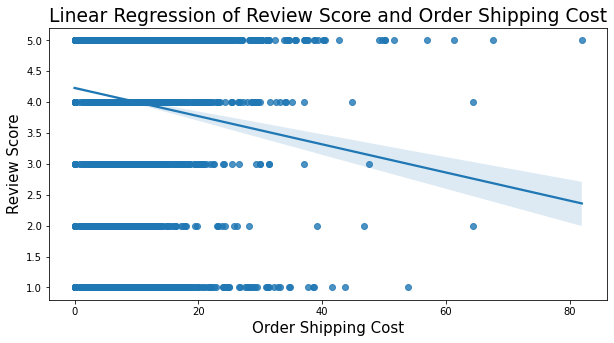

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Convert the PySpark DataFrame to a Pandas DataFrame
df = basetable_model.toPandas()

# Fit a linear regression using order_shipping_cost as independent variable and review_score as dependent variable
sns.regplot(x="order_shipping_cost", y="review_score", data=df)

# Add labels to the x and y axes and title to the plot
plt.xlabel('Order Shipping Cost', fontsize=15)
plt.ylabel('Review Score', fontsize=15)
plt.title('Linear Regression of Review Score and Order Shipping Cost', fontsize=18.75)

# Set the figsize and show the plot
plt.gcf().set_size_inches(10, 5)
plt.show()

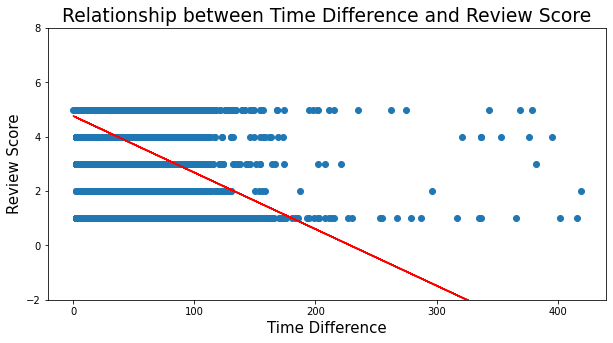

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

#Convert the PySpark DataFrame to a Pandas DataFrame
df = basetable_model.toPandas()

#Group the time differences into one factor
df['time_difference'] = df['delivery_time_difference_with_estimated'] + df['delivered_customer_time_difference_with_purchase'] + df['delivered_carrier_time_difference_with_purchase'] + df['estimate_delivery_time_difference_with_purchase'] + df['approval_time_difference_with_purchase']

#Fit the linear regression model
model = LinearRegression()
model.fit(df[['time_difference']], df['review_score'])

#Make predictions based on the time difference factor
df['predicted_review_score'] = model.predict(df[['time_difference']])

#Plot the relationship between time difference and review score
fig, ax = plt.subplots(figsize=(10,5))
ax.scatter(df['time_difference'], df['review_score'])
ax.plot(df['time_difference'], df['predicted_review_score'], color='red')
ax.set_xlabel('Time Difference', fontsize = 15)
ax.set_ylabel('Review Score', fontsize = 15)
ax.set_title('Relationship between Time Difference and Review Score', fontsize = 18.75)
ax.set_ylim(-2, 8)
plt.show()

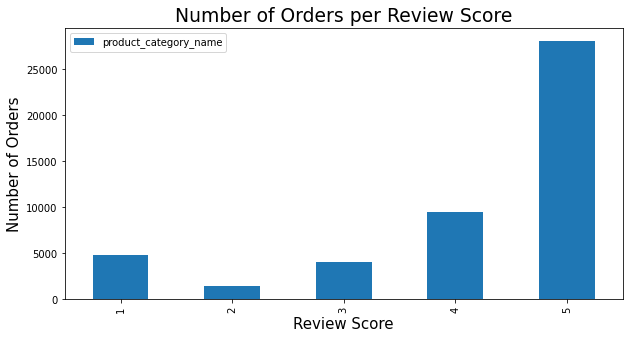

In [0]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert the PySpark DataFrame to a Pandas DataFrame
df = basetable_model.toPandas()

# Group the data by review score and count the number of each review score
grouped = df.groupby('review_score').agg({'product_category_name': 'count'})

# Plot the stacked bar chart
fig, ax = plt.subplots(figsize=(10,5))
grouped.plot(kind='bar', stacked=True, ax=ax)
plt.xlabel('Review Score', fontsize=15)
plt.ylabel('Number of Orders', fontsize=15)
plt.title('Number of Orders per Review Score', fontsize=18.75)
plt.show()